In [5]:
import pandas as pd
from scipy.io import arff

import plotly
plotly.tools.set_credentials_file(username='artemii-yanushevskyi', api_key='aRmQfG7U4SAlhISYVym7')

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import Image
import plotly.io as pio

import numpy as np
import seaborn as sns

from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
colormap = plt.cm.RdBu

exporting = False

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import importlib
import assistmodule
importlib.reload(assistmodule)

<module 'assistmodule' from '/Users/aware/Desktop/Data Mining/Data-Mining-at-Aston-University-Course/assistmodule.py'>

# Abstract

This report demonstrates the full process of developing a data mining solution for marketing campaign dataset, including critical insights and limitation of the solution, and how it could be improved.

As stated in the coursework specification for the solution, the goal of our first model is to predict, as accurately as possible, whether or not a client will subscribe to a term deposit. The goal of the second model for cost-sensitive classification is to make the total cost as small as possible. I apply multiple techniques like Feature Engineering, Parameter Tuning, and Boosting. Alongside the reasons why it should improve the prediction accuracy for equal cost classification and decrease the cost value for cost-sensitive classification.


# Introduction


We are given with the dataset about marketing campaigns that were based on phone calls. Each entry in the dataset corresponds to someone who has subscribed to a bank term deposit or not. Often more than one contact to the same client was required, in order to confirm if the product would (or not) be subscribed to.

The tools that I will use to develop the models are WRITTEN IN *Python* programming language, equipped with popular data mining library *sci-kit-learn*, data-frame manipulation library *Pandas*, NUMERICAL COMPUTING *NumPy*, and visualisation libraries *Plotly* and *Matplotlib*.

# Data Exploration

The dataset was supplied as an `arrf` file. The general description for attributes and statistics are the following

In [6]:
data, meta = arff.loadarff('cworkTrain.arff')
df = pd.DataFrame(data)
df_original = df

# all categorical attributes are in binary format

df = assistmodule.decode_dataframe(df)

display(
    'The dataset contains {} entries and {} attributes.'.format(*df.shape),
    df.head(),
    'There are 9 categorical and 8 numerical attributes.',
    'The statistics for categorical attributes:',
    df.select_dtypes([object]).describe(), 
    'The statistics for numerical attributes:',
    df.select_dtypes([float, int]).describe().round(1)
)

'The dataset contains 36169 entries and 17 attributes.'

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,termDeposit
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown,no
4,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5.0,may,139.0,1.0,-1.0,0.0,unknown,no


'There are 9 categorical and 8 numerical attributes.'

'The statistics for categorical attributes:'

,job,marital,education,default,housing,loan,contact,month,poutcome,termDeposit
count,36169,36169,36169,36169,36169,36169,36169,36169,36169,36169
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,7808,21746,18594,35512,20049,30363,23416,11013,29621,31981


'The statistics for numerical attributes:'

,age,balance,day,duration,campaign,pdays,previous
count,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0
mean,40.9,1352.8,15.8,256.7,2.8,39.9,0.6
std,10.6,3028.9,8.3,255.6,3.1,99.8,2.4
min,18.0,-6847.0,1.0,0.0,1.0,-1.0,0.0
25%,33.0,70.0,8.0,103.0,1.0,-1.0,0.0
50%,39.0,445.0,16.0,180.0,2.0,-1.0,0.0
75%,48.0,1417.0,21.0,317.0,3.0,-1.0,0.0
max,95.0,98417.0,31.0,4918.0,63.0,871.0,275.0


We convert attribute values month to the number (i.e. 'may' to 5) so that the ordering would have *chronological* sense (unlike alphabetical). 

The target attribute `termDeposit` is 'no' approximately 88.4%. That means that this is the baseline accuracy for classification. Now the baseline cost is for cost-sensitive classification is the minimum of $(36169-31981) * 10 = 41880$ ('no' for all) and $31981 * 1 = 31981$ ('yes' for all). The baseline cost is $31981$ for all 'yes' classifier. Also, we should convert the target attribute to 1 if the deposit is made and 0 if not.

In [7]:
df['month'] = pd.to_datetime(df.month, format='%b').dt.month
df['termDeposit'] = df['termDeposit'].apply(lambda x: 0 if x == 'no' else 1)

For 'termDeposit', notice that the team improves as time goes by. The number of deposits per each 1000 tries

In [ ]:
for i in range(37):
    print(sum(df['termDeposit'].values[i*1000:i*1000+1000]), end=' ')

Notice that the majority of _yes_'s are at the end of the data. We may want to shuffle rows. Also, we may use this insight to create a new feature. From 34,000 row until the end the half ARE 'yes'. However, this feature will not be useful since the test dataset doesn't have the same size.

The *feature attributes* are used to predict the *target attribute*. Originally the dataset has 16 feature attributes, 8 _categorical_ (including month) and 8 _numerical_. The quick check shows that there are no missing values in 36k labelled examples. 

## Histograms

In [ ]:
attributes = [atr for atr, typ in dict(df.dtypes).items()]
assistmodule.plotattributes(df, attributes, size=None)

Viewing the histograms for each variable showed that there were no variables that were strongly predictive of the class. Some attributes have quite imbalanced distributions of its values. Our algorithms may benefit from the Feature Engineering of some attribute values. 

## Pairplot

In [ ]:
sns.pairplot(df, hue='termDeposit');

Two-dimensional scatter plots don’t show strong class separation; this suggests that several attributes will be needed to separate the two classes.


Job some job attribute values may need to be merged into new groups. 
Some attributes may be irrelevant/redundant. The further exploration is needed to determine the significance of the attributes. The Pearson correlation shows how attributes depend on each other.

In order to see how *categorical* attributes are influencing `termDeposit` we need to *one-hot-encode* them.

In [8]:
df = assistmodule.one_hot_encode_categorical(df)
display(df.head())

1 job
2 marital
3 education
4 default
6 housing
7 loan
8 contact
15 poutcome


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,termDeposit
0,58.0,0,0,0,0,1,0,0,0,0,...,5,261.0,1.0,-1.0,0.0,0,0,0,1,0
1,44.0,0,0,0,0,0,0,0,0,0,...,5,151.0,1.0,-1.0,0.0,0,0,0,1,0
2,33.0,0,0,1,0,0,0,0,0,0,...,5,76.0,1.0,-1.0,0.0,0,0,0,1,0
3,47.0,0,1,0,0,0,0,0,0,0,...,5,92.0,1.0,-1.0,0.0,0,0,0,1,0
4,35.0,0,0,0,0,1,0,0,0,0,...,5,139.0,1.0,-1.0,0.0,0,0,0,1,0


In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(df_one_hot_ordered.astype(float).corr(),linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);

In [9]:
for c in df.columns:
    print(c)

age
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
education_primary
education_secondary
education_tertiary
education_unknown
default_no
default_yes
balance
housing_no
housing_yes
loan_no
loan_yes
contact_cellular
contact_telephone
contact_unknown
day
month
duration
campaign
pdays
previous
poutcome_failure
poutcome_other
poutcome_success
poutcome_unknown
termDeposit


In [10]:
df_pos = df[df['termDeposit'] == 1]
df_neg = df[df['termDeposit'] == 0]

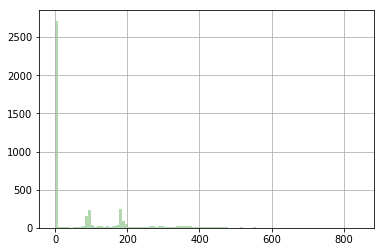

In [11]:
df_pos['pdays'].hist(bins=100, color='green', alpha=0.3)
#df_neg['pdays'].hist(bins=100, color='red', alpha=0.3)

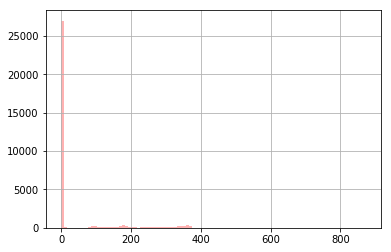

In [12]:
df_neg['pdays'].hist(bins=100, color='red', alpha=0.3)

TODO:
//observation: number of pdays for 
1. histograms of pdays
2. conditional histograms on job type
3. variable importance from decision tree
4. run RF with one_hot for all categorical
5. add metrics to classifier for cross validation (fscore, prec, rec) (f10 score)
pdays, duration, age, campaighn

FEATURE ENGINEERING
1. indicator variable: if pdays near 0, 

In [13]:
'''
CV & evaluation methods
Example:
baseline_cols = []
cv = create_cv(df, nFolds=3)
evaluate_on_cv(clf, df[baseline_cols + all_cols], df[ecn_col], cv)
'''
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def get_clf_res(y_true, y_pred, index):
    # returns df with 1 row and 9 columns (metrics that we are interested in)
    metrics_df = pd.DataFrame(
        columns=['TN', 'FP', 'FN', 'TP', 'Prec. cong', 'Prec. uncong', 'Rec. cong', 'Rec. uncong', 'f1 cong',
                 'f1 uncong',
                 'Acc. all', 'Supp. cong', 'Supp. uncong'], index=[index])

    # extracting metrics
    acc_all = accuracy_score(y_true, y_pred, normalize=True)
    prfs = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
    pr_uncong, pr_cong = prfs[0][0], prfs[0][1]
    rec_uncong, rec_cong = prfs[1][0], prfs[1][1]
    f1_uncong, f1_cong = prfs[2][0], prfs[2][1]
    sup_uncong, sup_cong = prfs[3][0], prfs[3][1]

    print(confusion_matrix(y_true, y_pred).ravel())
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # populate df
    metrics_df.iloc[0] = [tn, fp, fn, tp, pr_cong, pr_uncong, rec_cong, rec_uncong, f1_cong, f1_uncong,
                          acc_all, sup_cong, sup_uncong]

    # round values
    metrics_df.loc[index] = metrics_df.loc[index].apply(lambda x: round(x, 2))
    return metrics_df

def create_cv(df, nFolds=3):
    my_cv_iterator = []
    my_cv_iterator_masks = []

    for i in range(nFolds):
        ind = pd.Series(data=range(len(df)))
        start = int(len(df) * i / nFolds)
        end = int(len(df) * (i + 1) / nFolds)
        test_mask = ind.apply(lambda x: 1 if x >=  start and x < end else 0)

        test_indices = ind[test_mask > 0]
        train_mask = 1 - test_mask
        train_indices = ind[test_mask == 0]
        my_cv_iterator.append((train_indices, test_indices))
        my_cv_iterator_masks.append((train_mask, test_mask))

    # (!) return tuple, 
    # for evaluate_on_cv():   you need output[1]
    # for sklearn (cv input): you need output[0]
    return my_cv_iterator, my_cv_iterator_masks

def evaluate_on_cv(clf, X, y, cv):
    # print & return averaged main metrics
    train_mask = cv[1][0][0]
    test_mask = cv[1][0][1]
    y_true = y[test_mask == 1]
    y_pred = clf.fit(X[train_mask == 1], y[train_mask == 1]).predict(X[test_mask == 1])
    res = get_clf_res(y_true, y_pred, '')
    for i in range(1, len(cv[1])):
        train_mask, test_mask = cv[1][i]
        y_true = y[test_mask == 1]
        y_pred = clf.fit(X[train_mask == 1], y[train_mask == 1]).predict(X[test_mask == 1])
        res = pd.concat([res, get_clf_res(y_true, y_pred, '')])
    res.loc['avg'] = [res[c].mean() for c in res.columns]
    print(res.loc['avg'])
    return res.loc['avg']


In [14]:
clf = RandomForestClassifier()
df = df.sample(frac=1).reset_index(drop=True) # shuffle dataset
y = df['termDeposit']
X = df.drop('termDeposit', axis=1)

In [15]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [16]:
evaluate_on_cv(clf, X, y, create_cv(df, nFolds=3))
print(1)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[10379   260   982   435]
[10361   277   961   457]
[10459   245   929   424]
TN               10399.7
FP               260.667
FN               957.333
TP               438.667
Prec. cong      0.626667
Prec. uncong    0.916667
Rec. cong       0.313333
Rec. uncong     0.976667
f1 cong         0.416667
f1 uncong       0.943333
Acc. all             0.9
Supp. cong          1396
Supp. uncong     10660.3
Name: avg, dtype: object
1


In [17]:
arr = skf.split(X, y)

# Initial Classification
Let's apply classification models to our dataset as it is.

## Preparation: standardise numerical attributes

In [ ]:
df_numerical = df.select_dtypes([int, float]).drop('termDeposit', axis=1)
df_st_numerical = pd.DataFrame(StandardScaler().fit_transform(df_numerical.values), index=df_numerical.index, columns=df_numerical.columns)
df.update(df_st_numerical)

We noticed that the dataframe is not quite balanced, in particular, the success rate grows as number of tries increases. Thus we should shuffle the dataframe

In [ ]:
df = shuffle(df, random_state=42)
df_original = shuffle(df_original, random_state=42)


In [ ]:
scores = pd.DataFrame()
df_features = df.drop('termDeposit', axis=1)
df_target = df['termDeposit']

## The Default Classifier

In [ ]:
dummycls = DummyClassifier('most_frequent')
scorescv = cross_val_score(dummycls, df_features, df_target, cv=10)
scores['Default'] = pd.Series(scorescv)
scores[['Default']].describe()

## Decision Tree

In [ ]:
for min_impurity_decrease in [0.0001, 0.001, 0.01, 0.1, 1]:
    tree = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease)
    scorescv = cross_val_score(tree, df_features, df_target, cv=10)
    name = 'Tree ' + str(min_impurity_decrease)
    scores[name] = pd.Series(scorescv)

scores[[col for col in scores if col.startswith('Tree ')]].describe()

Notice the less the `min_impurity_decrease` is, the higher accuracy. However, the std is higher, thus the classification is less reliable.

Should we see the tree for some seed with `min_impurity_decrease = 0.001`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('termDeposit', axis=1), df['termDeposit'], test_size=0.1, random_state=45)
tree = DecisionTreeClassifier(min_impurity_decrease=0.001)
tree.fit(X_train, y_train)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree.predict(X_test)))
print(confusion_matrix(y_test, tree.predict(X_test)))
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This classifier is good enough. We can assert that it is better than the default classifier. Because the default classifier mean is way smaller than desision tree mean minus $3*std$.

## KNN

In [ ]:
knn_results = pd.DataFrame()

for n in range(1,16):
    knn_all_atr = KNeighborsClassifier(n_neighbors=n)
    scores_knn_all = cross_val_score(knn_all_atr, df_features, df_target, cv=10)
    knn_results['{}-NN'.format(n)] = pd.Series(scores_knn_all)

data = []
for col in knn_results.columns:
    data.append(go.Box(y=knn_results[col], name=col, showlegend=False ) )

data.append(go.Scatter(x=knn_results.columns, y = knn_results.mean(), mode='lines', name='mean'))

fig = go.Figure(data=data)

if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

Now I chose the best KNN results

In [ ]:
for n in [8, 13, 14, 15]:
    scores['{} Nearest N'.format(n)] = knn_results['{}-NN'.format(n)]

## Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=0, solver='sag', max_iter=10000)
scores_logreg = cross_val_score(logreg, df_features, df_target, cv=10)
scores['Logistic R'] = pd.Series(scores_logreg)

## Random Forest

In [ ]:
scores_randforest = pd.DataFrame()
for n in [10, 50]:
    randforest = RandomForestClassifier(n_estimators=n, verbose=True, n_jobs=-1)
    scores_randforest_cvs = cross_val_score(randforest, df_features, df_target, cv=10)
    scores_randforest['RF {} est'.format(n)] = pd.Series(scores_randforest_cvs)
    if n in [10, 15]:
        scores['RandomF {} trees'.format(n)] = pd.Series(scores_randforest_cvs)

data = []
for col in scores_randforest.columns:
    data.append(go.Box(y=scores_randforest[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores_randforest.columns, y = scores_randforest.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

In [ ]:
scores_randforest = pd.DataFrame()
for n in [500]:
    randforest = RandomForestClassifier(n_estimators=n,
                                        #max_depth=250,
                                        max_features=12,
                                        min_samples_leaf=3,
                                        verbose=True, 
                                        n_jobs=-1)
    scores_randforest_cvs = cross_val_score(randforest, df_features, df_target, cv=10)
    scores_randforest['RF {} est'.format(n)] = pd.Series(scores_randforest_cvs)
    if n in [10, 15]:
        scores['RandomF {} trees'.format(n)] = pd.Series(scores_randforest_cvs)

data = []
for col in scores_randforest.columns:
    data.append(go.Box(y=scores_randforest[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores_randforest.columns, y = scores_randforest.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

In [ ]:
#output_labels
#labels
incorrect_labels = np.and(labels, output_labels)
incorrect_clf_data = data[inctorrect_labels == True]
# explloratiry analysis of incorrect classified data
# just look at the raw data
# make some plots?

The more trees in the forest, the better.

# Summary

In [ ]:
data = []
for col in scores.columns:
    data.append(go.Box(y=scores[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores.columns, y = scores.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

# Feature Engineering

Having done preliminary inspection of the features, we will be prosess the features to make them more suitable for the classification algorithms.

## Job attribute

There are many different attribute values. It will negatively affect our prediction. We will group them by the percentage of 'yeses'.

Sorting attributes by the success rate

In [ ]:
# sort jobs by success rate
group_job = df_original.groupby(['job'])[['termDeposit']].mean().sort_values(['termDeposit'])
display(group_job)
# group into categories
groups = []
y = -np.inf
for x in [0.08, 0.1, 0.12, 0.15, 0.2, 0.25, 0.29]:
    group = group_job.index[(y < group_job.termDeposit) & (group_job.termDeposit < x)]
    groups.append(list(group))
    y = x

print('So the groups are', groups)
# create a column name for each group
colnames = []
for group in groups:
    colname = '-'.join([c[:4] for c in group])
    colnames.append(colname)
    
print(colnames)
df_jobs = df_original[['job']].copy(deep=True)
# create a column for each group
for i in range(len(groups)):
    newcol = [1 if job in groups[i] else 0 for job in df_jobs['job']]
    df_jobs['jobnew_' + colnames[i]] = newcol

# delete job
df_jobs = df_jobs.drop('job', axis=1)
df_jobs.head()

The union of the jobs in such groups is not arbitrary, I chose to group jobs that have very close success rate. Thus the future models would be trained on lager groups, it will boost accuracy for the jobs in minority.

In [ ]:
df = df.drop([col for col in df.columns if col.startswith('job_')], axis=1)
for col in df_jobs.columns:
    df.insert(1, col, df_jobs[[col]].values)

We have created new columns in our data

In [ ]:
df.head()

## Age

Notice that after 62 yo we see that subscription rate is constant being about 50%. Also, as we can see from histogram, the number of entries with age above 60 drops significantly.

So, for age that is above 66, we will set it to be equal to 67. Now the distribution of age reminds Gaussian distribution even more.

In [ ]:
df.loc[df['age'] > 66, 'age'] = 67

## Day and Month

In [ ]:
df['date'] = pd.Series(df_original['month'].astype(str).values + '.' +  df_original['day'].astype(int).astype(str).values)
df['date'] = pd.to_datetime(df['date'], format='%m.%d')

I created the new attribute `date`. It is defined as date via `day` and `month` attributes. Pay attention at the success rate by date.

In [ ]:
groupdate = df.groupby('date')[['termDeposit']].mean()
trace = go.Scatter(
    x = groupdate.index,
    y = groupdate['termDeposit'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=800,
    height=500)

data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

While exploring `month` attribute, I noticed that the success percentage is inversely proportional to the percentage of entries for this month

In [ ]:
groupby = pd.concat([
    df_original.groupby('month')[['termDeposit']].mean(),
    df_original.groupby('month')[['termDeposit']].count()/len(df)
], axis=1)

groupby.columns = ['mean', 'count']
display(groupby)

trace = go.Scatter(
    x = groupby['count'],
    y = groupby['mean'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=800,
    height=500)

data = [trace]
fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
iplot(fig)

It turns out that the same holds true even for the days. The more calls are done during the day, the lesser success rate becomes. It may be because the callers are focusing on the number of calls rather than persuading the audience to make term deposit.

In [ ]:
groupby = pd.concat([
    df.groupby('date')[['termDeposit']].mean(),
    df.groupby('date')[['termDeposit']].count()/max(df.groupby('date')[['termDeposit']].count().values)
], axis=1)
groupby.columns = ['mean', 'count']

trace = go.Scatter(
    x = groupby['count'],
    y = groupby['mean'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=800,
    height=500)

data = [trace]
fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
iplot(fig)

This suggests that we may want to replace the attributes `day`, `month`, and `date` by the number of calls on that day.

In [ ]:
??? df.groupby('date')[['date']].count()

It would be really nice if we have had the year. This way we can see how success rate depends on the day of the week.

We don't need to preserve `day`, `month`, and `date` attributes, since they have become redundant.

In [ ]:
df = df.drop(['day', 'month', 'date'], axis=1)

## Balance
This attribute is the most confusing. From the histogram we can infer that it is quite unlikely that for 10 present the balance attribute is between -8 and 8 pounds. It is either because their actual balance is different since they may use other means to save money. As a result the balance is not a good predictor for target attribute.

### Replacing
I will try to make balance to be more stronger estimation of the wealth by replacing the value between -8 and 8 by its estimation from more stronger predictors, such as: `education`, `marital`, `default`, `housing`, `loan`, `contact`, and `poutcome`.

The good predictors for balance attribute are

In [ ]:
df_test = df.copy(deep=True)

In [ ]:
df['balance'] = df_original['balance']

good_predictors_ind = [*range(1, 17), *range(18, 25), *range(31,35)]
good_predictors = []
for i in good_predictors_ind:
    good_predictors.append(df.columns[i])

print(good_predictors)

df_good_predictors = df[good_predictors]

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

mask = (df['balance'] < 8) & (df['balance'] > -8)
reg.fit(df_good_predictors.loc[~mask], df['balance'].loc[~mask])
df.loc[mask, 'balance'] = reg.predict(df_good_predictors.loc[mask])
df[['balance']].head()

### Logarithm
The second reason why this will be beneficial is because the distribution is lognormal, like all human generated data usually is. I will apply function $\log$ to the attribute values to oblatin a distribution close to Gaussian.

Now we can freely apply logarithm to the attribute balance.

In [ ]:
x = np.linspace(-1000, 1000, num=3000)
y = np.sign(x) * np.log(1 + np.abs(x))
              
trace = go.Scatter(x=x, y=y, marker={'color': 'red'}, 
                    mode="lines")
                                               
data = [trace]
layout=go.Layout(title="Graph of $\DeclareMathOperator{\sign}{sign} \sign(x)\cdot\log(1+|x|)$", xaxis={'title':'x'}, yaxis={'title':'y'})
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [ ]:
df_test = df.copy(deep=True)

In [ ]:
x = df['balance']
df['balance'] = np.sign(x) * np.log(1 + np.abs(x))
assistmodule.plotattributes(df, ['balance'], size=0.3)

Now we may standardise `balance` attribute.

In [ ]:
df['balance'] = (df['balance'] - df['balance'].mean())/df['balance'].std()

## Duration

The same approach, apply $log$

In [ ]:
x = df_original['duration']
df['duration'] = np.sign(x) * np.log(1 + np.abs(x))
assistmodule.plotattributes(df, ['duration'], size=0.1)

In [ ]:
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()

## Campaign

In [ ]:
x = df_original['campaign']
assistmodule.plotattributes(df_original, ['campaign'], size=0.1)
# x = 1/(2 + np.abs(x))
df['campaign'] = np.log(6 + x)
assistmodule.plotattributes(df, ['campaign'], size=0.01)

In [ ]:
df_original.groupby('campaign')[['termDeposit']].mean().head(9)

The `campaign` attribute requires no preprocessing, because it is already quite represents the success rate quite well. The success rate decreases as the campaign number increases, $\frac{1}{x}$-dependency.

## Pdays

It is not quite clear what strategy to use with `pdays` attribute.

In [ ]:
assistmodule.plotattributes(df, ['pdays'], size=0.01)

In [ ]:
x = df['pdays']
df['pdays'] = np.sign(2 + x) * np.log(2 + np.abs(x))
assistmodule.plotattributes(df, ['pdays'], size=0.1)

On each stage of the analysis, we can notice that `pdays` attribute does not constitute any significance for the target attribute. Thus it should not be taken into account.

In [ ]:
df = df.drop(['pdays'], axis=1)

## PCA for numerical attributes

The application of PCA for our numerical data had output the following result




In [ ]:
df_original.as

This is strengthtening the conclusion from Pearson correlation matrix that the .. attribute is the most predictive of the 'yes' class.

When applying classification we will use first .. PCA components that explain .. of the data.

In [ ]:
numerical = set(df_features.select_dtypes([int, float]).columns)
attributes = set(df.columns)
numerical = list(numerical & attributes)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_numerical = StandardScaler().fit_transform(df_numerical)

pca = PCA(n_components=3)

principal_components = pca.fit_transform(df_numerical)
principal_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'])
principal_df.head()

In [ ]:
final_df = pd.concat([principal_df, df[['termDeposit']]], axis = 1)
display(final_df.head(), final_df.describe())

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indices = final_df['termDeposit'] == target
    ax.scatter(final_df.loc[indices, 'PC1'],
               final_df.loc[indices, 'PC2'],
               c = color,
               s = 1,
               alpha=0.1)
ax.legend(targets)
ax.grid()

# Final Classification 

In [ ]:
scores = pd.DataFrame()
df = df.drop(['date'], axis=1)
df_features = df.drop('termDeposit', axis=1)
df_target = df['termDeposit']

## The Default Classifier

In [ ]:
dummycls = DummyClassifier('most_frequent')
scorescv = cross_val_score(dummycls, df_features, df_target, cv=10)
scores['Default'] = pd.Series(scorescv)
scores[['Default']].describe()

## Decision Tree

In [ ]:
for min_impurity_decrease in [0.0001, 0.001, 0.01, 0.1, 1]:
    tree = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease)
    scorescv = cross_val_score(tree, df_features, df_target, cv=10)
    name = 'Tree ' + str(min_impurity_decrease)
    scores[name] = pd.Series(scorescv)

scores[[col for col in scores if col.startswith('Tree ')]].describe()

Notice the less the `min_impurity_decrease` is, the higher accuracy. However, the std is higher, thus the classification is less reliable.

Should we see the tree for some seed with `min_impurity_decrease = 0.001`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('termDeposit', axis=1), df['termDeposit'], test_size=0.1, random_state=45)
tree = DecisionTreeClassifier(min_impurity_decrease=0.001)
tree.fit(X_train, y_train)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree.predict(X_test)))
print(confusion_matrix(y_test, tree.predict(X_test)))
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This classifier is good enough. We can assert that it is better than the default classifier. Because the default classifier mean is way smaller than desision tree mean minus $3*std$.

## KNN

In [ ]:
knn_results = pd.DataFrame()

for n in range(1,16):
    knn_all_atr = KNeighborsClassifier(n_neighbors=n)
    scores_knn_all = cross_val_score(knn_all_atr, df_features, df_target, cv=10)
    knn_results['{}-NN'.format(n)] = pd.Series(scores_knn_all)

data = []
for col in knn_results.columns:
    data.append(go.Box(y=knn_results[col], name=col, showlegend=False ) )

data.append(go.Scatter(x=knn_results.columns, y = knn_results.mean(), mode='lines', name='mean'))

fig = go.Figure(data=data)

if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

Now I chose the best KNN results

In [ ]:
for n in [8, 13, 14, 15]:
    scores['{} Nearest N'.format(n)] = knn_results['{}-NN'.format(n)]

## Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=0, solver='sag', max_iter=10000)
scores_logreg = cross_val_score(logreg, df_features, df_target, cv=10)
scores['Logistic R'] = pd.Series(scores_logreg)

## Random Forest

In [ ]:
scores_randforest = pd.DataFrame()
for n in range(1, 16):
    randforest = RandomForestClassifier(n_estimators=n)
    scores_randforest_cvs = cross_val_score(randforest, df_features, df_target, cv=10)
    scores_randforest['RF {} est'.format(n)] = pd.Series(scores_randforest_cvs)
    if n in [10, 15]:
        scores['RandomF {} trees'.format(n)] = pd.Series(scores_randforest_cvs)

data = []
for col in scores_randforest.columns:
    data.append(go.Box(y=scores_randforest[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores_randforest.columns, y = scores_randforest.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

The more trees in the forest, the better.

# Summary

In [ ]:
data = []
for col in scores.columns:
    data.append(go.Box(y=scores[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores.columns, y = scores.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))